In [1]:
import json, os, sqlite3, math
from pprint import pprint
from pathlib import Path
try:
    script_dir = Path(__FILE__).resolve().parent
except NameError:
    script_dir = Path('').resolve()

import torch
import torch.nn as nn
from torch.nn import functional as F

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay



In [2]:
class SQLite3Wrapper:
    def __init__(self, path='database.db'):
        self.connection = sqlite3.connect(path)
        self.cursor = self.connection.cursor()

    def table_exists(self, table_name):
        result = self.cursor.execute(f"SELECT name FROM sqlite_master WHERE type='table' AND name='{table_name}'")
        return result.fetchone() != None
    
    def execute(self, *args, **kwargs):
        return self.cursor.execute(*args, **kwargs)
    
    def print(self, *args, **kwargs):
        print(*args)
        print(kwargs)

    def ensure_create(self, table_name, attributes):
        if not self.table_exists(table_name):
            print('Creating table', table_name, 'with attributes', attributes)
            self.execute(f'CREATE TABLE {table_name}({attributes})')
    
    def count(self, table_name):
        return self.execute(f'SELECT COUNT(*) FROM {table_name}').fetchone()[0]
    
    def select(self, table_name):
        return self.execute(f'SELECT * FROM {table_name}').fetchall()
    
    def get(self, query, params=[], default=None):
        result = self.execute(query, params)
        result = result.fetchone()
        if result is None:
            return default
        else:
            return result[0]
    
    def print(self, table_name):
        for row in self.execute(f'SELECT * FROM {table_name}').fetchall():
            print(row)


In [3]:
def initialize_data(w):
    print('Loading raw data from csv file.')
    data = pd.read_csv('sources/dataset/Gungor_2018_VictorianAuthorAttribution_data-train.csv', encoding='latin-1')
    print('Putting raw data into sqlite table.')
    for index, row in data.iterrows():
        w.execute('INSERT INTO data VALUES (?, ?)', (row['text'], row['author']))
        print(row['author'])
    w.connection.commit()
    print('sqlite data table ready.')

def initialize_word_counts(w):
    # Not sure why I bothered making this.
    print('Counting words.')
    # w.execute('DELETE FROM word_counts')
    rows = w.execute('SELECT * FROM data').fetchall()
    for row in rows:
        text, author = row
        print('Author ', author, end='\r')
        for word in text.rstrip(' ').split(' '):
            old_count = w.execute('SELECT count FROM word_counts WHERE word = ?', (word,)).fetchone()
            if old_count is None:
                w.execute('INSERT INTO word_counts (word, count) VALUES (?, ?)', (word, 1))
            else:
                old_count ,= old_count
                w.execute('UPDATE word_counts SET count = ? WHERE word = ?', (old_count + 1, word))
        
    w.connection.commit()

    w.print('word_counts')
    print(w.count('word_counts'))

def initialize_id_word(w):
    rows = w.execute('SELECT * FROM data').fetchall()
    for row in rows:
        text, author = row
        print('Author ', author, end='\r')
        for word in text.rstrip(' ').split(' '):
            w.execute('INSERT OR IGNORE INTO id_word (word) VALUES (?)', [word])
    print()
    
    w.print('id_word')
    w.connection.commit()


In [4]:
w = SQLite3Wrapper()
w.ensure_create('data', 'words TEXT, author INT')

# w.ensure_create('word_counts', 'word VARCHAR(255), count INT')
# w.execute('CREATE UNIQUE INDEX IF NOT EXISTS index_word ON word_counts (word)')

# w.execute('DROP TABLE IF EXISTS id_word')
w.ensure_create('id_word', 'id INTEGER PRIMARY KEY, word VARCHAR(255) UNIQUE')
w.execute('CREATE UNIQUE INDEX IF NOT EXISTS index_word ON id_word (word)')

if w.count('data') < 53678: initialize_data(w)
if False: initialize_word_counts(w)
if w.count('id_word') < 10000: initialize_id_word(w)

word_to_id = {word:id for id, word in w.select('id_word')}
id_to_word = [None] + list(sorted((word for word, id in word_to_id.items()), key=lambda word : word_to_id[word]))

id_to_author = [None, 'Arthur Conan Doyle', 'Charles Darwin', 'Charles Dickens', 'Edith Wharton', 'George Eliot', 'Horace Greeley', 'Jack London', 'James Baldwin', 'Jane Austen', 'John Muir', 'Joseph Conrad', 'Mark Twain', 'Nathaniel Hawthorne', 'Ralph Emerson', 'Robert Louis Stevenson', 'Rudyard Kipling', 'Sinclair Lewis', 'Theodore Dreiser', 'Thomas Hardy', 'Walt Whitman', 'Washington Irving', 'William Carleton', 'Albert Ross', 'Anne Manning', 'Arlo Bates', 'Bret Harte', 'Catharine Maria Sedgwick', 'Charles Reade', 'Edward Eggleston', 'Fergus Hume', 'Frances Hodgson Burnett', 'George Moore', 'George William Curtis', 'Helen Mathers', 'Henry Rider Haggard', 'Isabella Lucy Bird', 'Jacob Abbott', 'James Grant', 'James Payn', 'John Kendrick Bangs', 'John Pendleton Kennedy', 'John Strange Winter', 'Lucas Malet', 'Marie Corelli', 'Oliver Optic', 'Sarah Orne Jewett', 'Sarah Stickney Ellis', 'Thomas Anstey Guthrie', 'Thomas Nelson Page', 'William Black']
author_to_id = {author:id for id, author in enumerate(id_to_author)}

rows = []
print('Loading rows into Python list')
for text, author in w.select('data'):
    words = text.rstrip(' ').split(' ')
    row = [word_to_id[word] for word in words] + [author]
    rows.append(row)
    print('Author:', author, end='\r')
print('\nDone loading rows')

print('Loading into dataframe')
data = pd.DataFrame(rows, columns=list(range(1000)) + ['author'])
print('Ok')

valid_authors = {id_author[0]:id_author[1] for id_author in enumerate(id_to_author) if id_author != None and id_author[0] in data['author'].values}
train_data, test_data = train_test_split(data, train_size=0.8, random_state=6128)
test_data = torch.tensor(test_data.values, dtype=torch.int64)


Loading rows into Python list
Author: 50 26 46
Done loading rows
Loading into dataframe
Ok


In [5]:
def pandas_row_to_words(pandas_row):
    index = sorted(i for i in pandas_row.index if isinstance(i, int))
    return ' '.join(id_to_word[pandas_row[word_index]] for word_index in index)

def get_author_rows(author_id):
    return data[data['author'] == author_id]

author_tensors = []
def get_author_tensor(author_id):
    while author_id >= len(author_tensors):
        rows = get_author_rows(len(author_tensors)).drop(['author'], axis=1)
        author_tensors.append(torch.tensor(rows.values, dtype=torch.int64))
    return author_tensors[author_id]

def tensor_to_words(t):
    if len(t.shape) == 0: return id_to_word[t.tolist()]
    if len(t.shape) == 1: return ' '.join(id_to_word[i] for i in t.tolist())
    return '\n'.join(tensor_to_words(subtensor) for subtensor in t)


In [6]:
# hyperparameters
batch_size = 24 # how many independent sequences will we process in parallel?
block_size = 128 # what is the maximum context length for predictions?
max_iters = 160000
eval_interval = 20000
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 64
n_head = 8
n_layer = 8
dropout = 0.3

torch.manual_seed(2965)
print('device is', device)

device is cuda


In [7]:
def get_batch(author_id=12):
    # Select random excerpt by the author
    #  then select random start point within the excerpt.
    data = get_author_tensor(author_id)
    selected_excerpts = torch.randint(data.shape[0], (batch_size,))
    selected_starts = torch.randint(data.shape[1] - block_size, (batch_size,))
    excerpt_start = torch.stack((selected_excerpts, selected_starts), axis=1)
    x = torch.stack([data[e][s:s+block_size] for e, s in excerpt_start]).cuda()
    y = torch.stack([data[e][s+1:s+block_size+1] for e, s in excerpt_start]).cuda()
    return x, y

# xb, yb = get_batch()
# print('inputs:')
# print(xb.shape)
# print(xb)
# print('targets:')
# print(yb.shape)
# print(yb)
# for b in range(batch_size): # batch dimension
#     for t in range(block_size): # time dimension
#         context = xb[b, :t+1]
#         target = yb[b,t]
#         print(f"when input is {repr(tensor_to_words(context))} the target is {repr(tensor_to_words(target))}")



In [8]:
@torch.no_grad()
def estimate_loss(model, author):
    model.eval()
    losses = torch.zeros(eval_iters)
    for k in range(eval_iters):
        X, Y = get_batch(author)
        logits, loss = model(X, Y)
        losses[k] = loss.item()
    model.train()
    return losses.mean()



In [9]:
class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x) # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

class BigramLanguageModel(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        self.vocab_size = vocab_size
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx


In [10]:
# check if there's a 'model.pth' in the directory before training the model
def load_or_train(author):
    model = BigramLanguageModel(vocab_size=len(id_to_word))
    m = model.to(device)

    models_dir = script_dir.joinpath('models')
    models_dir.mkdir(exist_ok=True)
    expected_path = models_dir.joinpath(f'model{author}.pth')
    if expected_path.exists():
        print(f"Loading model {author} '{id_to_author[author]}'...")
        model.load_state_dict(torch.load(expected_path))
    else:
        # create a PyTorch optimizer
        optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
        print(f"Training model for author {author} '{id_to_author[author]}',  {sum(p.numel() for p in m.parameters())/1e6:.2f} M params, {max_iters} iterations...")
        for iter in range(max_iters + 1):
            print('Iteration', iter, '           ', end='\r')
            # every once in a while evaluate the loss on train and val sets
            if iter % eval_interval == 0:
                loss = estimate_loss(model, author)
                print()
                print(f"step {iter}: loss {loss:.4f}")
        
            xb, yb = get_batch(author)
        
            # evaluate the loss
            logits, loss = model(xb, yb)
            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            optimizer.step()
        
        # save the model
        print('Saving model')
        torch.save(model.state_dict(), expected_path)
    print("Ok")

    return model



In [11]:
# valid_authors = {id: name for id, name in valid_authors.items() if id <= 40}
# print(valid_authors)
for author_id in valid_authors:
    load_or_train(author_id)
    


Loading model 1 'Arthur Conan Doyle'...
Ok
Loading model 2 'Charles Darwin'...
Ok
Loading model 3 'Charles Dickens'...
Ok
Loading model 4 'Edith Wharton'...
Ok
Loading model 6 'Horace Greeley'...
Ok
Loading model 8 'James Baldwin'...
Ok
Loading model 9 'Jane Austen'...
Ok
Loading model 10 'John Muir'...
Ok
Loading model 11 'Joseph Conrad'...
Ok
Loading model 12 'Mark Twain'...
Ok
Loading model 13 'Nathaniel Hawthorne'...
Ok
Loading model 14 'Ralph Emerson'...
Ok
Loading model 15 'Robert Louis Stevenson'...
Ok
Loading model 16 'Rudyard Kipling'...
Ok
Loading model 17 'Sinclair Lewis'...
Ok
Loading model 18 'Theodore Dreiser'...
Ok
Loading model 19 'Thomas Hardy'...
Ok
Loading model 20 'Walt Whitman'...
Ok
Loading model 21 'Washington Irving'...
Ok
Loading model 22 'William Carleton'...
Ok
Loading model 23 'Albert Ross'...
Ok
Loading model 24 'Anne Manning'...
Ok
Loading model 25 'Arlo Bates'...
Ok
Loading model 26 'Bret Harte'...
Ok
Loading model 27 'Catharine Maria Sedgwick'...
Ok
Load

In [12]:

# generate from the model
def generate_sample(model):
    context = torch.zeros((1, 1), dtype=torch.long, device=device)
    idx = model.generate(context, max_new_tokens=200)
    idx_list = idx[0][1:]
    return tensor_to_words(idx_list)
print(generate_sample(load_or_train(12)))


Loading model 12 'Mark Twain'...
Ok
speaking of her i d leave england with a jolly are heaps than you concluded that she has been for a certain degree for getting over the fall of mrs clear says that i say you also or description like some other person jumped up which the evidence against her dark and back on the contrary she looked well arrayed in nervous at the rusty manner do you know your errand sir that you stole it what do you mean man intend to do answered coolly he had a heart doctor if your thought cried with a smile pardon you have already been lost so far as they are really simple craft now then that s brain is all round my now false do you think that altered the papers i wish to wish to the bush and the he would have tried to trouble from a speech which was about to find its secret the man might be sure well though if any other gifts were strangers i left by the suggestion of the old man who was his servant and to doesn t replied readily lest he should kill the negro showin

In [13]:
def predict_probabilities(model, tensor):
    model.eval()
    with torch.no_grad():
        t_sample_prefix_logits, _ = model(tensor.unsqueeze(0))
    t_sample_prefix_logits = t_sample_prefix_logits
    t_prefix_logits = t_sample_prefix_logits[0]
    t_logits = t_prefix_logits[-1]
    return F.softmax(t_logits, dim=0)

def predict_probabilities2(model, tensor):
    # print('Evaluating model')
    with torch.no_grad():
        t_sample_prefix_logits, _ = model(tensor)
    # print('Doing softmax etc')
    t_sample_logits = t_sample_prefix_logits[:, t_sample_prefix_logits.shape[1] - 1, :]
    return F.softmax(t_sample_logits, dim=1)

def predict_word_ids(model, tensor):
    t_probabilities = predict_probabilities(model, tensor)
    top_word_things = torch.topk(t_probabilities, 5)

    best = []
    cumulative_probability = 0
    for word_id, word_probability in zip(top_word_things.indices, top_word_things.values):
        word_id = word_id.tolist()
        word_probability = word_probability.tolist()
        best.append((word_id, word_probability))
        cumulative_probability += word_probability
        if cumulative_probability >= 0.95:
            break
    
    return best

def predict_words(model, tensor):
    word_ids = predict_word_ids(model, tensor)
    words = [id_to_word[word_id] for word_id, probability in word_ids]
    return words

working_authorid = 12
working_model = load_or_train(working_authorid)
working_tensor = get_author_tensor(working_authorid)[10][:7]
working_tensor = working_tensor.to(device)
print('Seeing',
      repr(tensor_to_words(working_tensor[:-1])),
      '\nwe expect',
      predict_words(working_model, working_tensor[:-1]),
      'when the real value is',
      tensor_to_words(working_tensor[-1])
     )

Loading model 12 'Mark Twain'...
Ok
Seeing 'few days it is a forlorn' 
we expect ['hope', 'interest', 'amount', 'for', 'least'] when the real value is hope


In [14]:

# get the probability averaged over the input text
def get_prob_avg(model, tensor):
    tensor = tensor.to(device)
    model.eval()

    so_far = 0
    for i in range(block_size, tensor.shape[0] - block_size):
        start_point = i - block_size
        # if start_point < 0: start_point = 0
        probabilities = predict_probabilities(model, tensor[start_point:i])
        expected_id = tensor[i]
        context_start = i - 10;
        if context_start < 0: context_start = 0
        # print('Context:', tensor_to_words(tensor[context_start:i]), 'Expected:', tensor_to_words(expected_id), f'Observed: {probabilities[expected_id] * 100:.0f}%')
        so_far += probabilities[expected_id]
    return so_far / tensor.shape[0]

def get_prob_avg2(model, tensor):
    tensor = tensor.to(device)
    take_offsets = torch.arange(tensor.shape[0], device=device) * len(id_to_word)
    model.eval()

    acc = torch.zeros(tensor.shape[0], device=device)
    for i in range(block_size, tensor.shape[1] - block_size):
        start_point = i - block_size
        # print('Getting probabilities')
        probabilities = predict_probabilities2(model, tensor[:, start_point:i])
        # print(probabilities)
        # print('Getting ids')
        expected_ids = tensor[:, i]

        print(f'Round {i}    ', end='\r')
        # print()
        # print('Summing offsets')
        summed_offsets = expected_ids + take_offsets
        # print('Indexing probabilities')
        probs = probabilities.take(summed_offsets)
        # print('Converting probs to tensor')
        # probs = torch.as_tensor(probs)
        # print('Adding to total')
        acc += probs
    return acc / tensor.shape[1]

import time
start = time.time()
# print(f"Average probability of author 11 being author {12}: {get_prob_avg(load_or_train(11), get_author_tensor(12)[10]):.4f}")
print(f"Average probability of author 12 being author {12}: {get_prob_avg2(load_or_train(12), get_author_tensor(12)[10].unsqueeze(0))}")
# print(f"Average probability of author 13 being author {12}: {get_prob_avg(load_or_train(13), get_author_tensor(12)[10]):.4f}")
end = time.time()
print('Time diff: ', end - start)


Loading model 12 'Mark Twain'...
Ok
Average probability of author 12 being author 12: tensor([0.1262], device='cuda:0')
Time diff:  9.344681739807129


In [15]:
model_cache = {}
def get_model_cached(author_id):
    if not author_id in model_cache:
        model_cache[author_id] = load_or_train(author_id)
    return model_cache[author_id]


In [16]:

def get_author(tensor):
    best_probability = 0
    best_author = None
    for author_id in valid_authors:
        probability = get_prob_avg(get_model_cached(author_id), tensor)
        print(f'Chance author {author_id} {id_to_author[author_id]} wrote this tensor: {probability * 100:.2f}')
        if probability > best_probability:
            best_probability = probability
            best_author = author_id
    return best_author

def get_authors(sample_text):
    sample_bestprobability = [0] * sample_text.shape[0]
    sample_bestauthor = [None] * sample_text.shape[0]
    # count = 0
    # limit = 2
    for author_id in valid_authors:
        # count += 1
        # if count > limit:
        #     break
        sample_probability = get_prob_avg2(get_model_cached(author_id), sample_text)
        print('Author {author_id} {id_to_author[author_id]} done.')
        # for sample_index, probability in enumerate(sample_probability):
        #     print(f'Chance author {author_id} {id_to_author[author_id]} wrote tensor {sample_index}: {probability * 100:.2f}')
        for i in range(len(sample_bestprobability)):
            probability = sample_probability[i]
            best_probability = sample_bestprobability[i]
            if probability > best_probability:
                sample_bestprobability[i] = probability
                sample_bestauthor[i] = author_id
    return sample_bestauthor




In [17]:
segment_size = math.floor(test_data.shape[0] / 6)
segment_indices = []
for segment_index in range(6):
    start = segment_size * segment_index
    end = segment_size * (segment_index + 1)
    segment_indices += [(start, end)]
    
print(segment_indices)
print(test_data.shape)

expected_segments = []
for start, end in segment_indices:
    expected_segments.append(test_data[start:end, -1])
print([t.shape for t in expected_segments])



[(0, 1789), (1789, 3578), (3578, 5367), (5367, 7156), (7156, 8945), (8945, 10734)]
torch.Size([10736, 1001])
[torch.Size([1789]), torch.Size([1789]), torch.Size([1789]), torch.Size([1789]), torch.Size([1789]), torch.Size([1789])]


In [18]:
predicted_segments = [None, None, None, None, None, None]


In [19]:
for segment in [0]:#range(len(segment_indices)):
    segment_path = script_dir.joinpath(f'predictions{segment}.json')
    try:
        with segment_path.open() as segment_file:
            predicted_segments[segment] = json.load(segment_file)
        print(f'Loaded prediction segment {segment} from file.')
        continue
    except json.JSONDecodeError:
        pass
    
    start, end = segment_indices[segment]
    expected = expected_segments[segment]
    
    sample_textauthor = test_data[start:end]
    sample_text = sample_textauthor[:, :-1]
    predicted_segments[segment] = get_authors(sample_text)
    # print('Expected is\n\t', '\n\t'.join(f'{author_id}: {id_to_author[author_id]}' for author_id in sample_authorid))
    # print('Observed is\n\t', '\n\t'.join(f'{author_id}: {id_to_author[author_id]}' for author_id in predictions))
    with segment_path.open('w') as segment_file:
        json.dump(predicted_segments[segment], segment_file)

print(torch.tensor(predicted_segments[0]).shape)

Loaded prediction segment 0 from file.
torch.Size([1789])


In [20]:

working_predicted = []
working_true = []
for i in range(len(predicted_segments)):
    predicted = predicted_segments[i]
    if predicted is None: break
    working_predicted.append(predicted)
    working_true.append(expected_segments[i])
working_predicted = torch.flatten(torch.tensor(working_predicted))
working_true = torch.flatten(torch.stack(working_true))
print(working_predicted.shape)
print(working_true.shape)


torch.Size([1789])
torch.Size([1789])


In [21]:
print(working_predicted == working_true)
correct_count = torch.sum(working_predicted == working_true)
total_count = working_true.shape[0]
print(f'Correct: {correct_count} out of {total_count}, {correct_count / total_count * 100:.1f}%.')
# print(predicted_segments)
# print(predicted_segments[0])
# print(expected_segments[0].tolist())
# sample_predictedauthorid = torch.tensor(predictions)
# accuracy = torch.sum(sample_predictedauthorid == sample_authorid) / sample_authorid.shape[0]
# accuracy

tensor([True, True, True,  ..., True, True, True])
Correct: 1751 out of 1789, 97.9%.


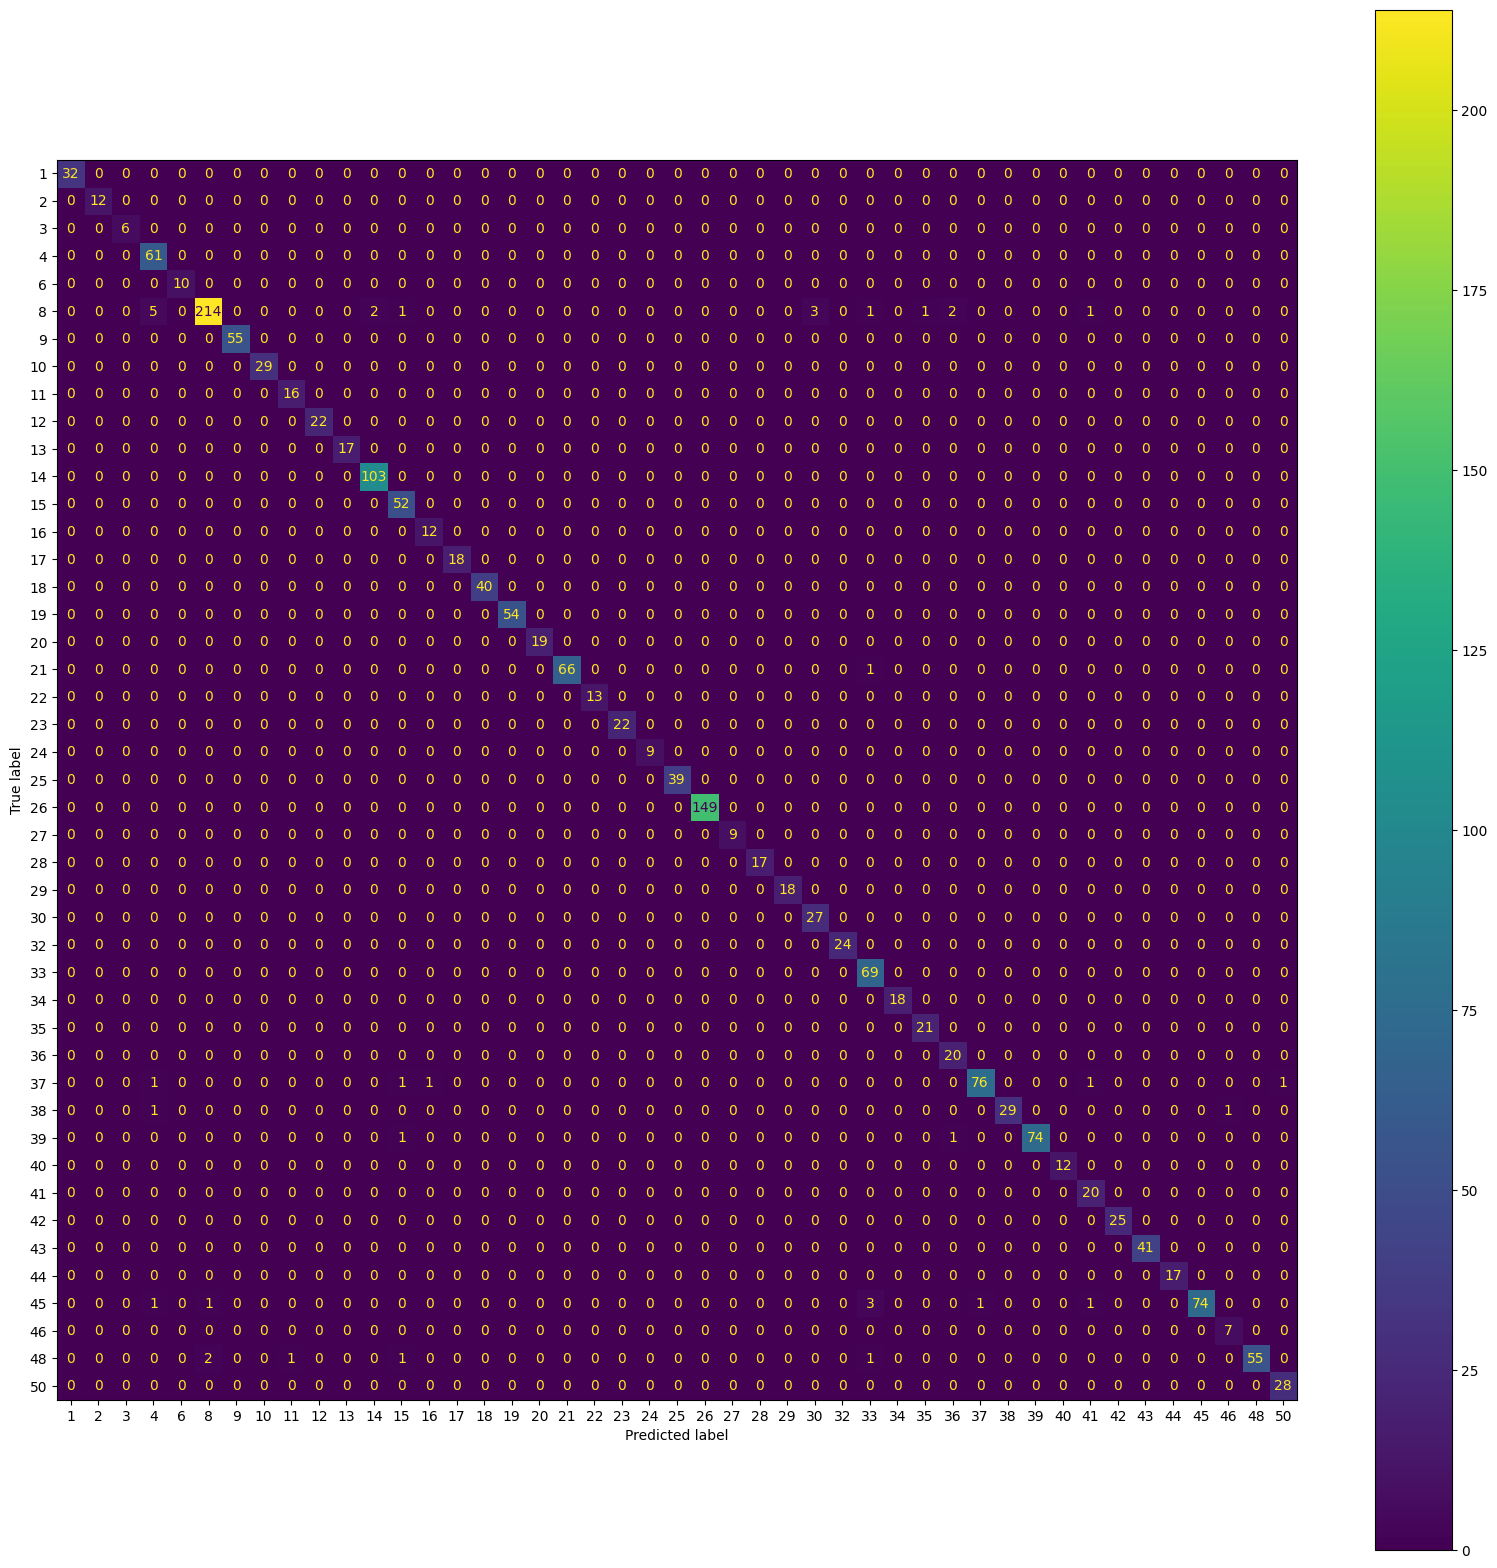

In [30]:
import matplotlib.pyplot as plt
# plt.figure(figsize=(20, 20))
figure = ConfusionMatrixDisplay.from_predictions(working_true, working_predicted, labels=sorted(list(valid_authors))).figure_
figure.set_size_inches(20, 20)
# figure

In [32]:

figure.savefig('confusion_matrix.pdf')
figure.savefig('confusion_matrix.png')
print('ok')

ok


In [64]:
from sklearn.metrics import f1_score

valid_author_ids = sorted(list(valid_authors))
author_scores_in_order = f1_score(working_true, working_predicted, average=None)
print(f"Macro-averaged f1 score: {f1_score(working_true, working_predicted, average='macro') * 100:.2f}%")

print('f1 score per true author:')
table = pd.DataFrame({'author':[valid_authors[id] for id in valid_author_ids], 'score':author_scores_in_order})
index = pd.Index(valid_author_ids)
table = table.set_index(index)
table


Macro-averaged f1 score: 98.35%
f1 score per true author:


,author,score
1,Arthur Conan Doyle,1.000000
2,Charles Darwin,1.000000
3,Charles Dickens,1.000000
4,Edith Wharton,0.938462
6,Horace Greeley,1.000000
8,James Baldwin,0.957494
9,Jane Austen,1.000000
10,John Muir,1.000000
11,Joseph Conrad,0.969697
12,Mark Twain,1.000000
